In [2]:
# Connexion au répertoire
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Imports

In [3]:
# Libraries
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL
import cv2

# Data Analysis
import matplotlib.pyplot as plt

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

# Config

In [4]:
# Chemin d'accès ### A MODIFIER EN LOCAL !!
path = "/content/gdrive/MyDrive/Projet Radio_DS/data/"
ID_DIR = 6

# Accès aux sous-dossiers
dirsi = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsim = ["Normal/masked_images/","COVID/masked_images/","Lung_Opacity/masked_images/","Viral Pneumonia/masked_images/"]


# Images à traiter (brutes ou masquées) et taille échantillon
dirs = dirsim
ECH_SIZE = 2000 #(max 2000 sur images masquées par seul un échantillon dispo)

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia")
nbClasses = len(classes)

# Paramètres
SIZE = (256,256)
RATIO_VAL = 0.2
BATCH_SIZE = 32 # Batch pour générateur d'images
MODEL_BATCH_SIZE = 32 # Batch pour entrainement modèle
NB_EPOCHS = 30

# Création des dataframes

In [5]:
### Création des listes d'emplacement pour chaque catégorie

liste_paths = [] #Sert à créer le dataframe
liste_test = [] # Sert à conserver toujours les mêmes mages de test (pour tous les modèles)
test_size = int(RATIO_VAL * ECH_SIZE // nbClasses) # Taille de l'échantillon de test à conserver pour chaque catégorie

for class_dir in dirs :
  class_images_names = [fn for fn in os.listdir(path + class_dir) if fn.endswith('.png')]
  for filename in class_images_names[0: (ECH_SIZE // nbClasses)] :
    liste_paths.append(path + class_dir + filename)

  # Récupération d'un échantillon de test
  for i in range(test_size):
    liste_test.append(liste_paths[-test_size:][i])
  liste_paths = liste_paths[:-test_size]

# Récupération de la catégorie de chaque image
liste_paths = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_paths))
liste_test = list(map(lambda x : [x, x.split('/')[ID_DIR]], liste_test))

In [6]:
# Création d'un DataFrame Entrainement et de validation
df = pd.DataFrame(liste_paths, columns = ['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df =  df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

print(df["nameLabel"].value_counts())
df.head()

COVID              400
Normal             400
Lung_Opacity       400
Viral Pneumonia    400
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,/content/gdrive/MyDrive/Projet Radio_DS/data/C...,COVID,1
1,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
2,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
3,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
4,/content/gdrive/MyDrive/Projet Radio_DS/data/L...,Lung_Opacity,2


In [7]:
# Création du DataFrame de test
df_test = pd.DataFrame(liste_test, columns = ['filepath', 'nameLabel'])
df_test['label'] = df_test['nameLabel'].replace(df_test.nameLabel.unique(), [*range(len(df_test.nameLabel.unique()))])
df_test['label'] = df_test['label'].astype(str)

# Nettoyage variables inutiles
del liste_test

print(df_test["nameLabel"].value_counts())
df_test.head()

Normal             100
COVID              100
Lung_Opacity       100
Viral Pneumonia    100
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
1,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
2,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
3,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0
4,/content/gdrive/MyDrive/Projet Radio_DS/data/N...,Normal,0


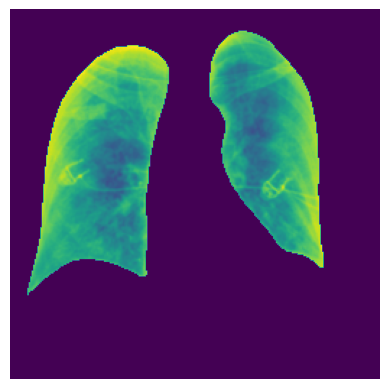

In [8]:
### Exemple d'image

filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

# Itérateurs d'images

In [9]:
# Séparation dataframe en ensemble entrainement et validation
train, valid = train_test_split(df, test_size=RATIO_VAL, shuffle = False)


# Création des itérateurs qui chargeront des lots d'images
train_data_generator = ImageDataGenerator( )
valid_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Initialisation du image generator de train
print(f"Number of rows in train set: {len(train)}")
train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = SIZE, #Resize
                                                           batch_size = BATCH_SIZE,
                                                           color_mode = "grayscale"
                                                           )

# Initialisation du image generator de validation
print(f"Number of rows in valid set: {len(valid)}")
valid_generator = valid_data_generator.flow_from_dataframe(dataframe = valid,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         color_mode = "grayscale",
                                                         shuffle = False)


# Initialisation du image generator de test
print(f"Number of rows in test set: {len(df_test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = df_test, #Utilisation du dataframe de test
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = SIZE, #Resize
                                                         batch_size = BATCH_SIZE,
                                                         color_mode = "grayscale", # Pas de grayscale, en rgb
                                                         shuffle = False)

Number of rows in train set: 1280
Found 1280 validated image filenames belonging to 4 classes.
Number of rows in valid set: 320
Found 320 validated image filenames belonging to 4 classes.
Number of rows in test set: 400
Found 400 validated image filenames belonging to 4 classes.


# Création du modèle

In [10]:
# Instanciation modèle séquentiel
model = Sequential()

# Ajout des différentes couches
model.add(Conv2D(filters = 30 , kernel_size = (5,5), input_shape =[256,256,1], activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dropout(rate = 0.2))

model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = nbClasses, activation = "softmax"))

# Compilation
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "Adam", metrics = ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 30)      780       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 30)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 16)      4336      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dropout (Dropout)           (None, 61504)             0

# Callbacks

In [11]:
#Création de callbacks

#checkpoint
checkpoint = ModelCheckpoint( path + 'model.h5',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'auto',
                             verbose = 1)

#early stopping'
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          mode = 'auto',
                          verbose = 1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode = 'auto',
                              verbose = 1)

# Entrainement du modèle

In [12]:
# Récupération des tailles d'échantillon
train_size = train_generator.samples
valid_size = valid_generator.samples

# Entrainement du modèle avec callbacks
history = model.fit(train_generator,
                    epochs = NB_EPOCHS,
                    steps_per_epoch = train_size // MODEL_BATCH_SIZE,
                    validation_data = valid_generator,
                    validation_steps = valid_size // MODEL_BATCH_SIZE,
                    verbose = 1,
                    callbacks = [earlystop, reduce_lr])

Epoch 1/30
40/40 [==============================] - 311s 7s/step - loss: 29.8226 - accuracy: 0.3547 - val_loss: 1.1428 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 2/30
40/40 [==============================] - 4s 106ms/step - loss: 0.9214 - accuracy: 0.6648 - val_loss: 0.9196 - val_accuracy: 0.6219 - lr: 0.0010
Epoch 3/30
40/40 [==============================] - 5s 121ms/step - loss: 0.5484 - accuracy: 0.8055 - val_loss: 0.8849 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
40/40 [==============================] - 4s 95ms/step - loss: 0.2559 - accuracy: 0.9109 - val_loss: 0.9658 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 5/30
40/40 [==============================] - 4s 98ms/step - loss: 0.0879 - accuracy: 0.9852 - val_loss: 1.0647 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 6/30
40/40 [==============================] - 4s 94ms/step - loss: 0.0306 - accuracy: 0.9984 - val_loss: 1.2153 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 7/30
40/40 [==============================] - 4s 96ms/step - loss: 

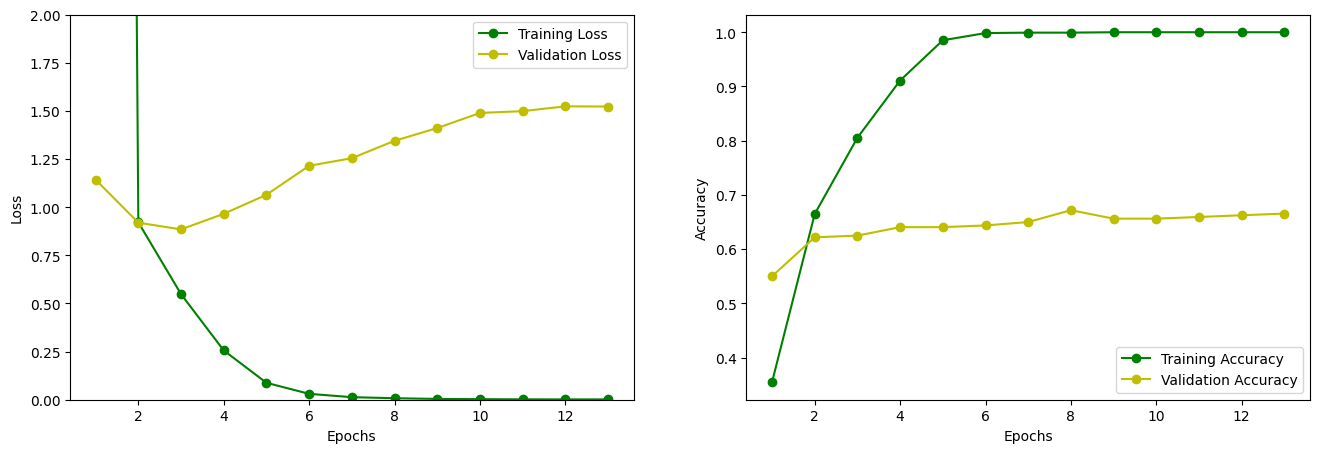

In [13]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

# Courbe de perte
plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Loss')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

# Courbe d'accuracy
plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

# Evaluation des performances

In [14]:
#Acccuracy et perte pour ensemble entrainement, validation et test
print('TRAIN loss & accuracy :', model.evaluate(train_generator))
print('\n')
print('VALID loss & accuracy :', model.evaluate(valid_generator))
print('\n')
print('TEST loss & accuracy :', model.evaluate(test_generator))

40/40 [==============================] - 4s 92ms/step - loss: 8.7409e-04 - accuracy: 1.0000
TRAIN loss & accuracy : [0.0008740909397602081, 1.0]


10/10 [==============================] - 1s 72ms/step - loss: 1.5230 - accuracy: 0.6656
VALID loss & accuracy : [1.5229710340499878, 0.6656249761581421]


13/13 [==============================] - 76s 6s/step - loss: 1.9529 - accuracy: 0.5525
TEST loss & accuracy : [1.952944040298462, 0.5525000095367432]


In [15]:
# Calcul des prédictions (test)

y_pred = np.argmax(model.predict(test_generator), axis = 1)

13/13 [==============================] - 1s 66ms/step


In [16]:
# Fonction d'affichage de matrice de confusion
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


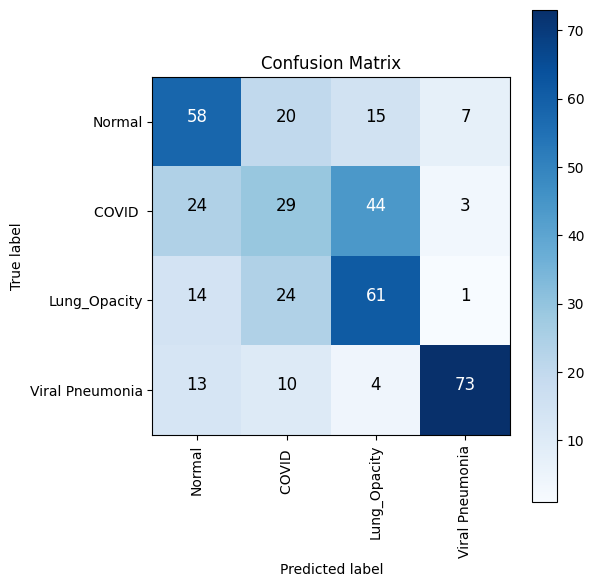

In [17]:
# Calcul et affichage matrice de confusion
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes, normalize = False)

In [18]:
# Rapport de classification

print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.58      0.56       100
           1       0.35      0.29      0.32       100
           2       0.49      0.61      0.54       100
           3       0.87      0.73      0.79       100

    accuracy                           0.55       400
   macro avg       0.56      0.55      0.55       400
weighted avg       0.56      0.55      0.55       400



# Prédictions sur des images test

In [19]:
# Stockage de l'ensemble de test en array
X_test = []
for filepath in tqdm(df_test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, SIZE)
    X_test.append([im])

X_test = tf.concat(X_test, axis = 0)

100%|██████████| 400/400 [00:01<00:00, 321.17it/s]


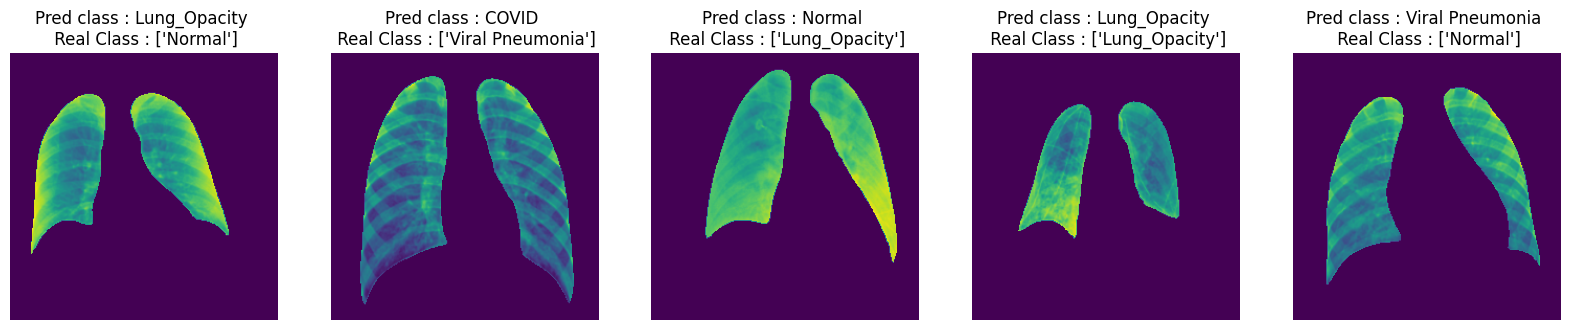

In [20]:
# Choix d'images au hasard et affichage

y_test = pd.DataFrame(test_generator.classes).astype(int)

indices_random = tf.random.uniform([5], 0, len(df_test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,10))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df_test.nameLabel.unique()[y_pred[idx]], df_test.nameLabel.unique()[y_test.values[idx]]))

# Sauvegarde et chargement modèles

In [21]:
#Enregistrement modèle
model.save_weights(path + "model_lenet_2000im_30ep.h5")

In [22]:
#Chargement modèle
model.load_weights(path + "model_lenet_2000im_30ep.h5")